# XGBoost for the Predicting the Beats-per-Minute of Songs Competition

Link to the competition: https://www.kaggle.com/competitions/playground-series-s5e9/overview

It's one of Kaggle's playground competitions with synthetic data, nothing serious but fun to try some things out

In [1]:
from itertools import combinations
from typing import Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("data/preprocessed_train.csv", index_col="id")

In [2]:
df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511
5,0.594579,-11.715431,0.101701,0.000005,0.259634,0.024300,0.639254,161012.2221,0.938333,151.43602


## Baseline Model

In [3]:
y = df['BeatsPerMinute']
X = df.drop(columns=['BeatsPerMinute'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [5]:
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [6]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

n = 500

model = xgb.train(
    params, xgb_train, num_boost_round=n, evals=[(xgb_test, "test")], early_stopping_rounds=30
)

[0]	test-rmse:23.29122
[1]	test-rmse:23.29089
[2]	test-rmse:23.28950
[3]	test-rmse:23.28841
[4]	test-rmse:23.28773
[5]	test-rmse:23.28690
[6]	test-rmse:23.28634
[7]	test-rmse:23.28635
[8]	test-rmse:23.28641
[9]	test-rmse:23.28594
[10]	test-rmse:23.28563
[11]	test-rmse:23.28560
[12]	test-rmse:23.28556
[13]	test-rmse:23.28587
[14]	test-rmse:23.28586
[15]	test-rmse:23.28581
[16]	test-rmse:23.28586
[17]	test-rmse:23.28565
[18]	test-rmse:23.28589
[19]	test-rmse:23.28609
[20]	test-rmse:23.28596
[21]	test-rmse:23.28605
[22]	test-rmse:23.28620
[23]	test-rmse:23.28598
[24]	test-rmse:23.28573
[25]	test-rmse:23.28613
[26]	test-rmse:23.28637
[27]	test-rmse:23.28674
[28]	test-rmse:23.28692
[29]	test-rmse:23.28705
[30]	test-rmse:23.28710
[31]	test-rmse:23.28721
[32]	test-rmse:23.28677
[33]	test-rmse:23.28709
[34]	test-rmse:23.28711
[35]	test-rmse:23.28716
[36]	test-rmse:23.28710
[37]	test-rmse:23.28726
[38]	test-rmse:23.28754
[39]	test-rmse:23.28777
[40]	test-rmse:23.28768
[41]	test-rmse:23.28724


In [7]:
preds = model.predict(xgb_test)
rmse = root_mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
print('rmse of the model is:', rmse)
print('r2 of the model is:', r2)

rmse of the model is: 23.28770198010605
r2 of the model is: 0.0004336332146026578


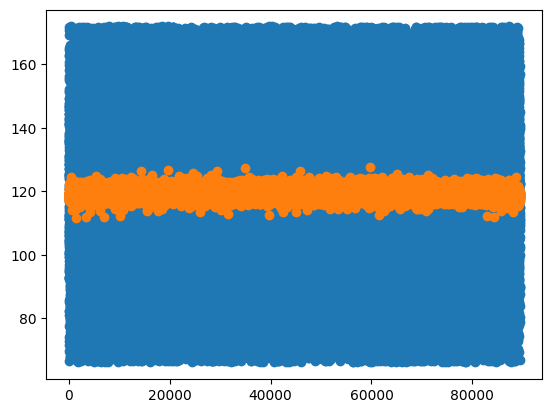

In [8]:
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(y_test)), preds)

## Mean Baseline

In [9]:
preds = np.array([y_train.mean()] * len(y_test))

In [10]:
rmse = root_mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
print('rmse of the mean is:', rmse)
print('r2 of the mean is:', r2)

rmse of the mean is: 23.292852019483835
r2 of the mean is: -8.520791726418508e-06


## Feature Engineering

In [12]:
def _safe_log1p(s: pd.Series) -> pd.Series:
    """log1p with automatic shifting to avoid log of <= -1 values."""
    s = s.astype(float)
    minv = s.min()
    if np.isfinite(minv) and minv <= -1.0:
        shift = (-minv) + 1.0
        return np.log1p(s + shift)
    return np.log1p(s)

def _sqrt01(s: pd.Series) -> pd.Series:
    """sqrt for features expected in [0,1]; clamps into [0,1] before sqrt."""
    return np.sqrt(np.clip(s.astype(float), 0.0, 1.0))

def _square(s: pd.Series) -> pd.Series:
    return s.astype(float) ** 2

def _cube(s: pd.Series) -> pd.Series:
    return s.astype(float) ** 3

def _ratio(a: pd.Series, b: pd.Series, eps: float = 1e-8) -> pd.Series:
    return a.astype(float) / (b.astype(float) + eps)

def _quantile_bin(s: pd.Series, q: int):
    """Return integer bin ids 0..(k-1) using q-quantiles.
    Falls back gracefully if unique values < q."""
    s = pd.to_numeric(s, errors="coerce")
    # try qcut; if not enough unique values, shrink q
    k = min(q, max(1, s.nunique(dropna=True)))
    if k == 1:
        return pd.Series(np.zeros(len(s), dtype="int32"), index=s.index)
    try:
        bins = pd.qcut(s, q=k, labels=False, duplicates="drop")
    except ValueError:
        # extreme duplicates, fallback to cut on unique values count
        bins = pd.cut(s, bins=k, labels=False, include_lowest=True)
    return bins.astype("int32")


def make_transforms(
    df: pd.DataFrame,
    *,
    exclude: Iterable[str] = (),
    log_cols: Iterable[str] = (),
    sqrt_cols: Iterable[str] = (),
    square_cols: Iterable[str] = (),
    cube_cols: Iterable[str] = (),
    interactions: Iterable[Tuple[str, str]] = (),
    auto_interactions_from: Iterable[str] = (),
    auto_interactions_k: int = 0,
    ratios: Iterable[Tuple[str, str]] = (),
    auto_ratios_from: Iterable[str] = (),
    auto_ratios_k: int = 0,
    standardize_cols: Iterable[str] = (),
    drop_original: bool = False,
    # NEW:
    quantile_bin_cols: Iterable[str] = (),
    quantile_bins: int = 10,
    quantile_as: str = "category",  # "category" | "int" | "onehot"
) -> pd.DataFrame:    
    """
    Build a transformed design matrix from df with flexible knobs.

    Parameters
    ----------
    exclude : columns to ignore entirely (e.g., the target)
    log_cols/sqrt_cols/square_cols/cube_cols : columns to transform
    interactions : explicit list of pairwise products e.g. [("Energy","RhythmScore")]
    auto_interactions_from : columns to consider for auto pairwise products (all unique pairs)
    auto_interactions_k : if >0, limit to first k pairs (alphabetical order) to keep size in check
    ratios : explicit list of ratios e.g. [("VocalContent","InstrumentalScore")]
    auto_ratios_from : columns to consider for auto pairwise ratios a/b (ordered)
    auto_ratios_k : if >0, limit to first k ordered pairs
    standardize_cols : columns to z-score (done after all creations)
    drop_original : if True, drops originals of transformed columns (keeps others)
    """

    df = df.copy()
    base_cols = [c for c in df.columns if c not in set(exclude)]

    out = df[base_cols].copy()

    # — basic transforms
    for c in log_cols:
        if c in out:
            out[f"{c}_log1p"] = _safe_log1p(out[c])
    for c in sqrt_cols:
        if c in out:
            out[f"{c}_sqrt"] = _sqrt01(out[c])
    for c in square_cols:
        if c in out:
            out[f"{c}_sq"] = _square(out[c])
    for c in cube_cols:
        if c in out:
            out[f"{c}_cu"] = _cube(out[c])

    # — interactions (products)
    for a, b in interactions:
        if a in out and b in out:
            out[f"{a}__x__{b}"] = out[a].astype(float) * out[b].astype(float)

    if len(auto_interactions_from) > 0:
        cand = [c for c in auto_interactions_from if c in out]
        pairs = list(combinations(sorted(cand), 2))
        if auto_interactions_k > 0:
            pairs = pairs[:auto_interactions_k]
        for a, b in pairs:
            out[f"{a}__x__{b}"] = out[a].astype(float) * out[b].astype(float)

    # — ratios
    for a, b in ratios:
        if a in out and b in out:
            out[f"{a}__div__{b}"] = _ratio(out[a], out[b])

    if len(auto_ratios_from) > 0:
        cand = [c for c in auto_ratios_from if c in out]
        ordered_pairs = [(a, b) for a in cand for b in cand if a != b]
        if auto_ratios_k > 0:
            ordered_pairs = ordered_pairs[:auto_ratios_k]
        for a, b in ordered_pairs:
            out[f"{a}__div__{b}"] = _ratio(out[a], out[b])

    if len(quantile_bin_cols) > 0:
        for c in quantile_bin_cols:
            if c not in out:
                continue
            b = _quantile_bin(out[c], q=quantile_bins)
            colname = f"{c}_q{quantile_bins}"
            if quantile_as == "onehot":
                dmy = pd.get_dummies(b, prefix=colname, dtype=float)
                out = pd.concat([out, dmy], axis=1)
            elif quantile_as == "int":
                out[colname] = b.astype("int32")
            else:  # "category"
                out[colname] = pd.Categorical(b)
                
    if drop_original:
        to_drop = set(log_cols) | set(sqrt_cols) | set(square_cols) | set(cube_cols)
        out = out[[c for c in out.columns if c not in to_drop]]

    return out

In [13]:
X_transforms = make_transforms(
    X,
    log_cols=df.columns,
    sqrt_cols=df.columns,
    square_cols=df.columns,
    cube_cols=df.columns,
    auto_interactions_from=df.columns,
    auto_interactions_k=5,
    auto_ratios_from=df.columns,
    auto_ratios_k=5,
)

## PCA

In [14]:
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [15]:
pca = PCA(n_components=7)

X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

In [16]:
columns = [f"PCA{i+1}" for i in range(7)]

df_pca = pd.DataFrame(X_pca, columns=columns)

In [17]:
sum(explained_variance)

np.float64(0.8630423089916692)

## ICA

In [18]:
transformer = FastICA(n_components=7,
        random_state=0,
        whiten='unit-variance')
X_ica = transformer.fit_transform(X)
X_ica.shape

(357528, 7)

In [19]:
columns = [f"ICA{i+1}" for i in range(7)]

df_ica = pd.DataFrame(X_ica, columns=columns)

## Feature Selection

In [20]:
def eval_xgb_regression(
    X: pd.DataFrame,
    y: pd.Series,
    features: list | None = None,
    test_size: float = 0.25,
    random_state: int = 0,
    params: Optional[Dict] = None,
    num_boost_round: int = 1000,
    early_stopping_rounds: int = 50,
) -> Dict[str, float]:
    """Train/validate XGBoost with early stopping; returns metrics and model."""
    if params is None:
        params = {
            "objective": "reg:squarederror",
            "max_depth": 5,
            "learning_rate": 0.1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "eval_metric": "rmse",
        }

    if features:
        X = X[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dtest, "valid")],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False,
    )

    preds = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return {
        "rmse": float(rmse),
        "r2": float(r2),
        "best_iteration": int(model.best_iteration),
        "n_features": int(X.shape[1]),
        "model": model,
        "X_test": X_test,
        "y_test": y_test,
        "preds": preds,
        "model": model
    }

In [21]:
X_combined = pd.concat([X_transforms.reset_index(drop=True), df_ica, df_pca], axis=1)

In [22]:
y = y.reset_index(drop=True)

In [23]:
result = eval_xgb_regression(
    X=X_combined,
    y=y
)
model = result["model"]
importance = model.get_score(importance_type="weight")
best_weight = dict(filter(lambda x: x[1] > 150, reversed(sorted(importance.items(), key=lambda x: x[1])))).keys()
importance = model.get_score(importance_type="gain")
best_gain = dict(filter(lambda x: x[1] > 6000, reversed(sorted(importance.items(), key=lambda x: x[1])))).keys()
# best_features = list(set(list(best_weight) + list(best_gain)))
best_features = list(best_gain)

best_features

['LivePerformanceLikelihood_sq',
 'RhythmScore_cu',
 'AcousticQuality_sq',
 'RhythmScore_log1p',
 'MoodScore_log1p']

In [24]:
result = eval_xgb_regression(
    X=X_combined[best_features],
    y=y,
    params={
        "objective": "reg:squarederror",
        "max_depth": 3,
        "learning_rate": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "eval_metric": "rmse",
    }
)

In [25]:
result['rmse']

23.28636328430912

In [26]:
result['r2']

0.0005485502497196704

## Tuning

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=0)

In [38]:
# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01],
#     'subsample': [0.7, 1],
#     'colsample_bytree': [0.7, 1],
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0, 0.1, 0.5],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1, 5, 10],
#     "early_stopping_rounds": [20]
# }

# xgb_model = xgb.XGBRegressor(random_state=0)

# grid_search = GridSearchCV(
#     xgb_model,
#     param_grid,
#     cv=5,
#     scoring='neg_root_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(
#     X_train[best_features],
#     y_train,
#     eval_set=[(X_test[best_features], y_test)],
#     verbose=False
# )

# # Print best results
# print("Best set of hyperparameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

In [76]:
#best_iter = grid_search.best_estimator_.best_iteration
best_params = {"objective": "reg:squarederror", 'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.11, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}

In [77]:
result = eval_xgb_regression(
    X=X_combined[best_features],
    y=y,
    params=best_params,
    num_boost_round=best_params['n_estimators']
)

/Users/kuba/Repos/predicting-the-beats-per-minute/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [22:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [78]:
result['rmse']

23.286396726955825

In [68]:
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_combined[best_features], y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
df_test = pd.read_csv("data/test.csv", index_col="id")

In [34]:
X_test_transforms = make_transforms(
    df_test,
    log_cols=df.columns,
    sqrt_cols=df.columns,
    square_cols=df.columns,
    cube_cols=df.columns,
    auto_interactions_from=df.columns,
    auto_interactions_k=5,
    auto_ratios_from=df.columns,
    auto_ratios_k=5,
)
sc = StandardScaler()

X_test_scaled = sc.fit_transform(df_test)
pca = PCA(n_components=7)

X_test_pca = pca.fit_transform(X_test_scaled)
columns = [f"PCA{i+1}" for i in range(7)]
df_test_pca = pd.DataFrame(X_test_pca, columns=columns)

transformer = FastICA(
    n_components=7,
    random_state=0,
    whiten='unit-variance'
)
X_test_ica = transformer.fit_transform(df_test)
columns = [f"ICA{i+1}" for i in range(7)]
df_test_ica = pd.DataFrame(X_test_ica, columns=columns)

X_test = pd.concat([X_test_transforms.reset_index(drop=True), df_test_ica, df_test_pca], axis=1)

In [35]:
preds = xgb_model.predict(X_test[best_features])

In [36]:
df_test['BeatsPerMinute'] = preds

In [37]:
df_test['BeatsPerMinute'].reset_index().to_csv("submission4.csv", index=False)